## Zadanie - klasyczna detekcja obiektów

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Celem zadania będzie zaprojektowanie algorytmu detekcji i analizy obiektów,
pozwalającego na zliczenie leków poszczególnych gatunków z podziałem na komórki organizera.

Występuje 7 klas obiektów; od lewej w górnym rzędzie
* `line`\*: czerwono-białe kapsułki
* `keto`: niebieskie tabletki
* `carbon`: duże czarne kapsułki
* `probio`: duże białe kapsułki
* `biox`: małe białe tabletki
* `espu`: małe żółte kapsułki
* `dexi`\*: niebiesko-szare kapsułki (w dolnym rzędzie)

In [3]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.morphology import remove_small_objects
from tqdm import tqdm

from itertools import product
from typing import List, Tuple

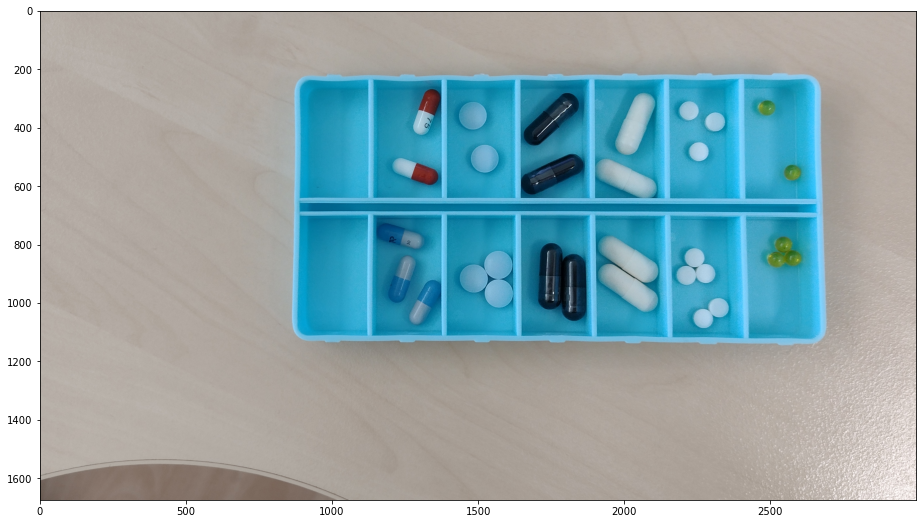

In [4]:
calib = cv2.imread('Lab 5 - dane-20221024/calib.png')
plt.subplots(1, 1, figsize=(16,9))[1].imshow(calib[..., ::-1]);

### Zadanie 1
Wykorzystując narzędzia poznane na poprzednich zajęciach (konwersja przestrzeni barw, detekcja krawędzi, binaryzacja, etc.) oraz [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), zaproponuj algorytm detekcji obiektów (funkcja `detect_objects`).
Poprawnie działający algorytm powinien zwracać listę konturów lub bounding boksów reprezentujących poszczególne obiekty
(czy nawet dowolnych obiektów zawierających jedno i drugie).

W zależności od przyjętego podejścia, doimplementuj metodę `display_objects`, by wyświetlić rezultaty.

Podpowiedzi:
* zacznij od górnego wiersza, z pominięciem dwukolorowych kapsułek
* w drugiej kolejności podejmij problem stykających się obiektów
* dwukolorowe kapsułki są "dla ambitnych"

In [5]:
class PillDetector():
  def __init__(self):
    self.axes = None
  
  def _crop_box(self, org_image: np.ndarray, border: int = 25, plot: bool = False):
    """Detects box and crops an image to it"""
    image = org_image.copy()

    # Otsu threshold on saturation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[..., 1].astype(np.uint8)
    th, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Binary closing of holes
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (300, 300))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    # Contour finding and cropping (box - maximal area contour)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
    x, y, w, h = cv2.boundingRect(contours[0])
    roi = org_image[y + border : y + h - border, x + border : x + w - border]

    if plot:
      fig, axes = plt.subplots(1, 3, figsize=(28, 22))
      fig.suptitle(f"Box cropping pipeline", fontsize=20, y=.62)

      axes[0].imshow(org_image[..., ::-1])
      axes[0].set_title("Original image")
      axes[0].axis("off") 

      axes[1].imshow(image)
      axes[1].set_title("Threshold based segmentation")
      axes[1].axis("off")

      axes[2].imshow(roi[..., ::-1])
      axes[2].axis("off")
      axes[2].set_title("Cropped image (with border removal)")

      plt.show()

    return roi

  def _mark_instances(self, org_image: np.ndarray, mask: np.ndarray, open_iters: int = 4, plot: bool = False, pill_name: str = None):
    """Mark individual instances on the binary mask"""
    image = org_image.copy()

    # Binary opening - shrinking objects
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=open_iters)

    # Prior labelling - for distance thresholding
    _, prior_markers = cv2.connectedComponents(mask.astype(np.uint8))

    # Distance transform + markers - extracting centers of instances
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    marker_map = np.zeros_like(dist_transform)

    for i in range(1, prior_markers.max() + 1):
      dist_instance = dist_transform * (prior_markers == i)
      instance_map = dist_instance > (0.6 * dist_instance.max())
      marker_map += instance_map

    marker_map = (marker_map > 0).astype(np.uint8)

    # Calculating grow region for objects
    grow_region = cv2.dilate(mask, kernel, iterations=3)
    grow_region = grow_region - marker_map

    # Component marking + watershed
    _, markers = cv2.connectedComponents(marker_map.astype(np.uint8))
    markers += 1
    markers[grow_region == 255] = 0
    markers = cv2.watershed(image, markers)

    # Plotting
    if plot:
      fig, axes = plt.subplots(1, 4, figsize=(28, 22))
      fig.suptitle(f"Pill '{pill_name}' instance segmentation pipeline", fontsize=20, y=.58)

      axes[0].imshow(prior_markers)
      axes[0].set_title("Blobs from rough threshold-based segmentation")
      axes[0].axis("off") 

      axes[1].imshow(dist_transform)
      axes[1].set_title("Distance transform")
      axes[1].axis("off")

      axes[2].imshow(marker_map)
      axes[2].axis("off")
      axes[2].set_title("Instance markers")
      
      self.axes = axes

    return markers

  def _extract_bbs(self, label_mask: np.ndarray, min_size: int = 0, max_size: int = np.inf, plot: bool = False):
    """Exracts bbs from labelled mask"""
    objects = []
    
    for i in range(2, label_mask.max() + 1):
      object_mask = (label_mask == i).astype(np.uint8)
      contours, hierarchy = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      if len(contours) > 0:
        contour = contours[0]

        if min_size < cv2.contourArea(contour) < max_size:
          rect = cv2.boundingRect(contour)
          objects.append({"bb": rect, "area": cv2.contourArea(contour)})

    if plot:
      self.axes[-1].imshow(label_mask)  
      self.axes[-1].set_title("Instance segmentation (with size filtering)")
      self.axes[-1].axis("off")

      for obj in objects:
        x, y, w, h = obj["bb"]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        self.axes[-1].add_patch(rect)

    return objects

  def _find_keto_pills(self, org_image: np.ndarray, plot: bool = False):
    """Detects bbs of keto (blue) pills"""
    image = org_image.copy()

    # Threshold all objects
    image_s = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[..., 1]
    objects = (image_s < 145).astype(np.uint8)

    # Blue color range thresholding - RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(image, (80, 140, 190), (120, 180, 255))

    # Remove small structures
    mask = remove_small_objects(mask > 0, min_size=400)
    mask = mask.astype(np.uint8) * 255
    
    # Extract components from objects
    _, labelled_objects = cv2.connectedComponents(objects)
    components = np.unique(labelled_objects * (mask > 0))    
    components = components[components != 0]
    mask = np.isin(labelled_objects, components)
    mask = mask.astype(np.uint8) * 255

    markers = self._mark_instances(image, mask, open_iters=0, plot=plot, pill_name="keto")  
    bbs = self._extract_bbs(markers, min_size=4000, max_size=7000, plot=plot)

    return bbs

  def _find_biox_pills(self, org_image: np.ndarray, plot: bool = False):
    """Detects bbs of biox (white circular) pills"""
    image = org_image.copy()
    
    # White color range thresholding - RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(image, (120, 120, 120), (255, 255, 255))
    
    markers = self._mark_instances(image, mask, plot=plot, pill_name="biox")  
    bbs = self._extract_bbs(markers, min_size=1000, max_size=4000, plot=plot)
    
    return bbs

  def _find_probio_pills(self, org_image: np.ndarray, plot: bool = False):
    """Detects bbs of probio (white long) pills"""
    image = org_image.copy()
    
    # White color range thresholding - RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(image, (120, 120, 120), (255, 255, 255))
    
    markers = self._mark_instances(image, mask, plot=plot, pill_name="probio")  
    bbs = self._extract_bbs(markers, min_size=4000, plot=plot)
    
    return bbs

  def _find_espu_pills(self, org_image: np.ndarray, plot: bool = False):
    """Detects bbs of espu (green) pills"""
    image = org_image.copy()

    # Green color range thresholding - a from HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))    

    markers = self._mark_instances(image, mask, open_iters=2, plot=plot, pill_name="espu")    
    bbs = self._extract_bbs(markers, plot=plot)

    return bbs

  def _find_carbon_pills(self, org_image: np.ndarray, plot: bool = False):
    """Detects bbs of carbon (black) pills"""
    image = org_image.copy()

    # Black color range thresholding - GRAYSCALE
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.blur(image_gray, (10, 10))
    mask = cv2.inRange(image_gray, 0, 45)

    # Binary closing - remove specular highlights
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=4)

    markers = self._mark_instances(image, mask, plot=plot, pill_name="carbon")  
    bbs = self._extract_bbs(markers, min_size=8000, plot=plot)
    
    return bbs

  def run(self, org_image: np.ndarray, plot_pipeline: bool = False):
    box = self._crop_box(org_image, plot=plot_pipeline)

    objects = {
      "espu": self._find_espu_pills(box, plot=plot_pipeline),
      "carbon": self._find_carbon_pills(box, plot=plot_pipeline),
      "biox": self._find_biox_pills(box, plot=plot_pipeline),
      "probio": self._find_probio_pills(box, plot=plot_pipeline),
      "keto": self._find_keto_pills(box, plot=plot_pipeline)
    }
    return objects, box

In [6]:
def display_objects(_image: np.ndarray, objects: np.ndarray, _box: np.ndarray) -> None:
  image = _image.copy()
  box = _box.copy()

  COLORMAP = {
    'keto': (0, 0, 255),
    'carbon': (0, 0, 0),
    'probio': (255, 255, 255),
    'biox': (255, 0, 255),
    'espu': (255, 255, 0),
    'line': (255, 0, 0),
    'dexi': (127, 127, 127)
  }

  fig, axes = plt.subplots(1, 2, figsize=(24, 10))

  for name, object_list in objects.items():
    colormap = COLORMAP[name]

    for object in object_list:
      x, y, w, h = object["bb"]
      cv2.rectangle(box, (x, y), (x + w, y + h), colormap, 4)
      cv2.putText(box, f"{name}: {object['area']}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colormap, 2)

  axes[0].imshow(cv2.cvtColor(box, cv2.COLOR_BGR2RGB))
  axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  axes[0].axis("off")
  axes[1].axis("off")

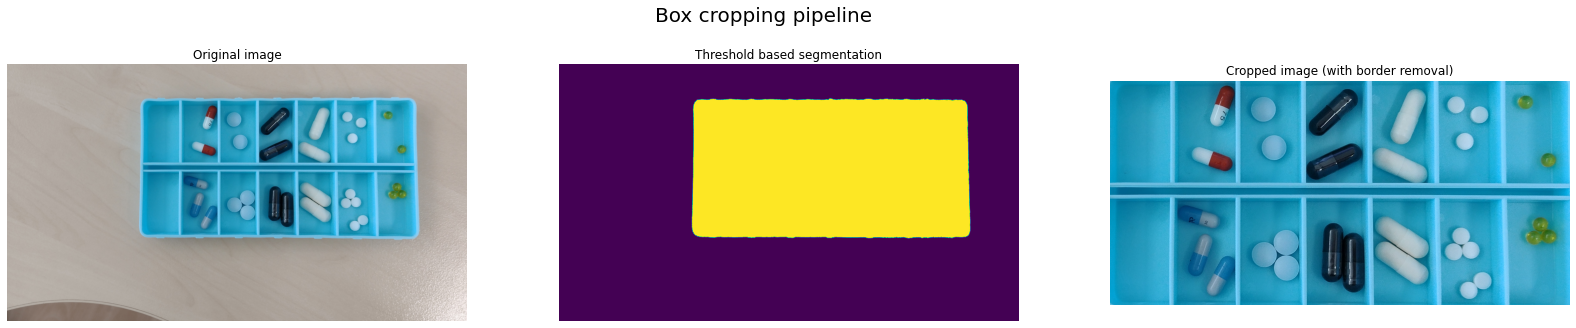

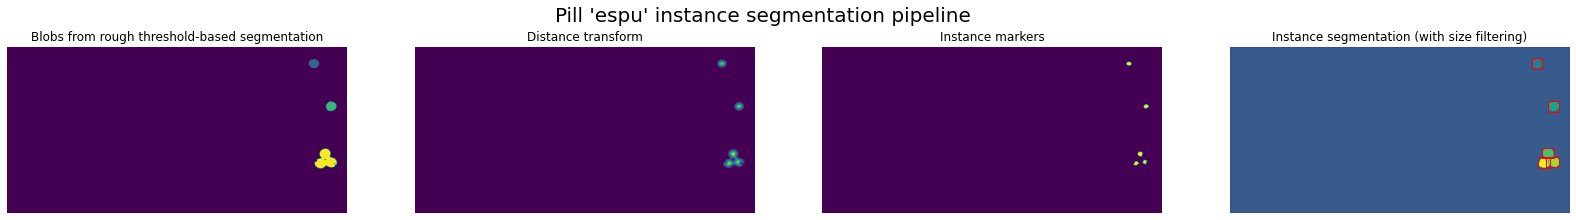

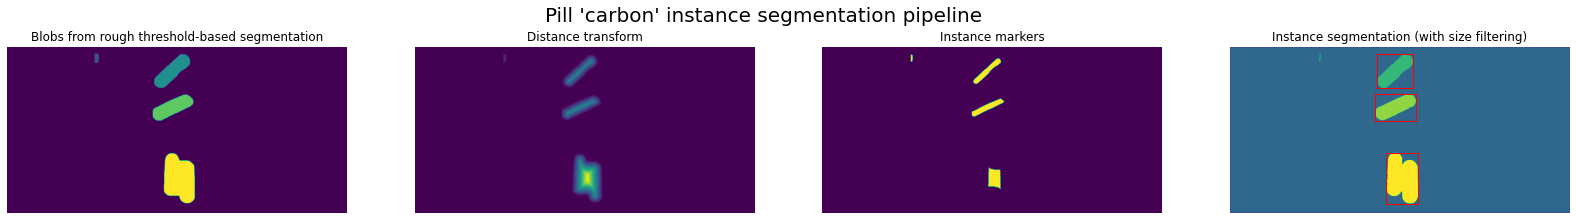

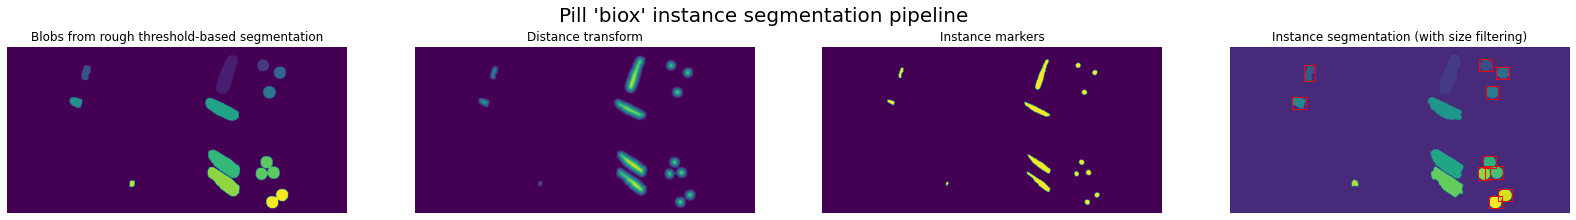

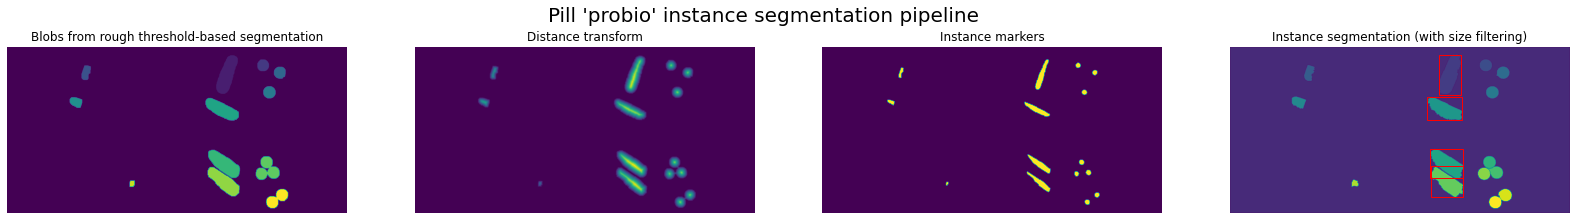

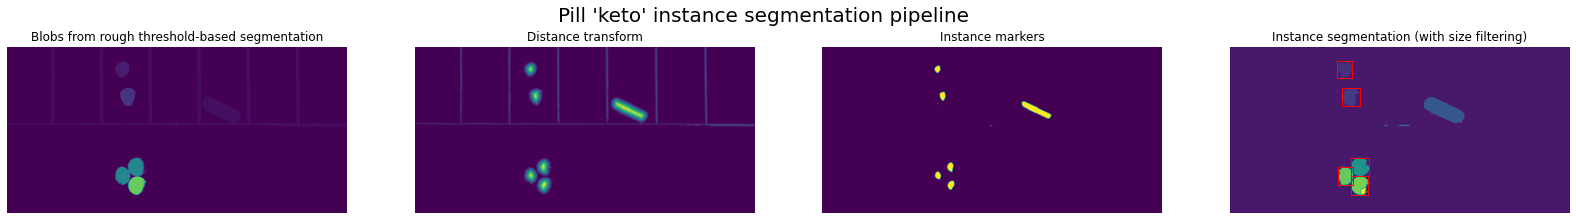

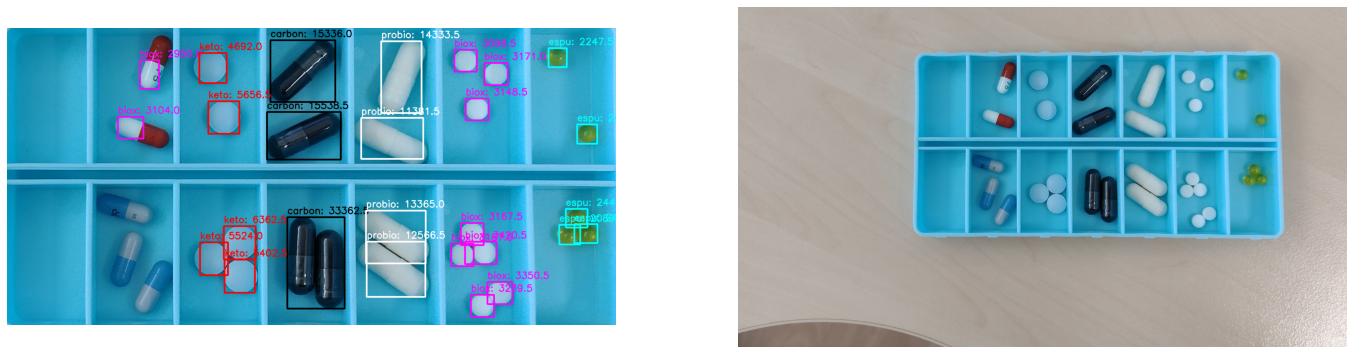

In [7]:
display_objects(calib, *PillDetector().run(calib, plot_pipeline=True))

### Zadanie 2
Dodaj do pipeline'u przetwarzania algorytm analizy obiektów, pozwalający na rozróżnienie obiektów poszczególnych klas.
Podejście jest zupełnie dowolne:
możesz zaimplementować go jako osobną procedurę (post-processing uzyskanych konturów) opartą o analizę kształtu i barwy,
możesz próbować zintegrować go z detekcją obiektów.
Obowiązuje tylko jedno zastrzeżenie: algorytm powinien być "klasyczny", tj. bez użycia uczenia maszynowego.

Jakkolwiek zdecydujesz, wyjściem algorytmu powinny być poetykietowane obiekty (kontur/bbox + etykieta).
Dodaj implementację funkcji `display_recognized` do rysowania wykrytych instancji;
skorzystaj z podanej mapy kolorów.

_Pro-tip do podejścia z post-processingiem konturów: zapoznaj się z metodami [zaawansowanego indeksowania macierzy](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing) w numpy, zwłaszcza indeksowaniem za pomocą macierzy binarnej. TL;DR: `obraz[maska]` powoduje odwołanie się tylko do tych pikseli obrazu `obraz`, które odpowiadają położeniem niezerowym pikselom maski._

### Zadanie 3

Przetestuj uzyskany algorytm na obrazach `test1.png`, `test2.png` i `test3.png`.
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

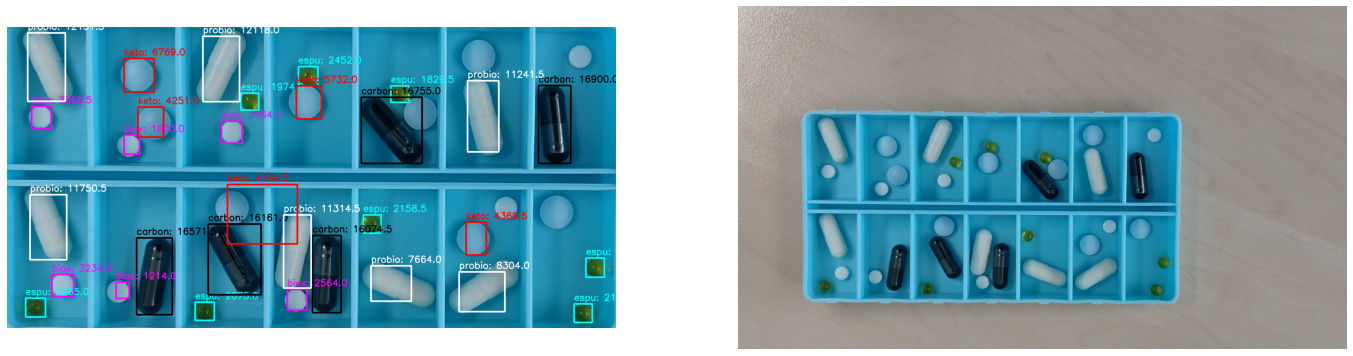

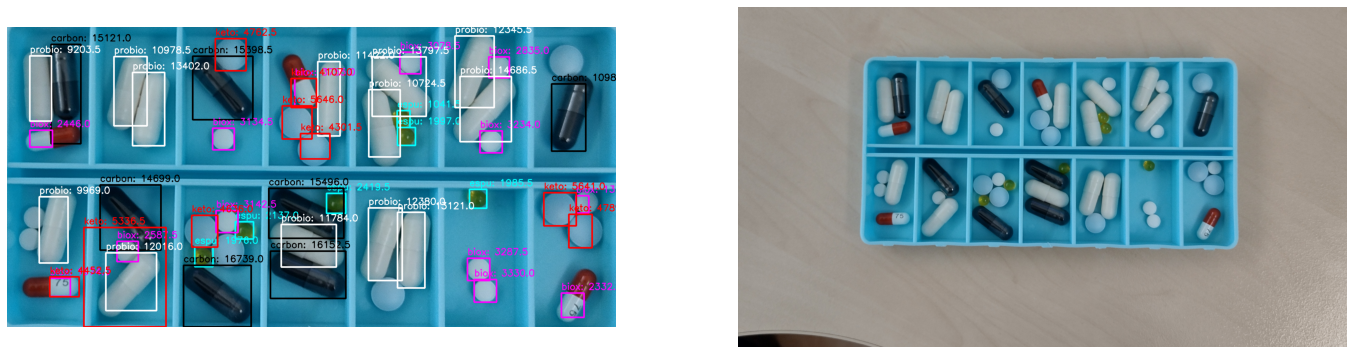

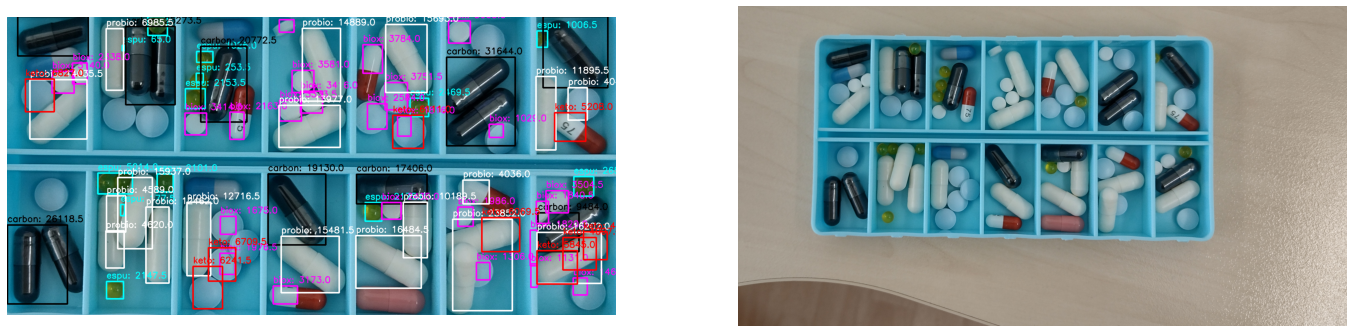

In [64]:
for i in range(3):
    img = cv2.imread(f'Lab 5 - dane-20221024/test{i + 1}.png')
    display_objects(img, *PillDetector().run(img))

* Najgorzej rozpoznawanymi tabletkami są 'keto' (niebieskie) - głównie ze względu na to, że w porównaniu do pozostałych tabletek nie są one łatwo odzielane od tła po kolorze. 
* Tabletki biox są także czasmi pomijane ze względu na to, że są małe i na kolor biały jest często w cieniu i ma lekko niebieskawy odcień.
* Tabletki bardzo blisko siebie lub na sobie tej samej klasy potrafią zostać nie prawidłowo uznane za jedną instancję.

In [ ]:
# miejsce na poprawki algorytmu

### Zadanie 4

Wykorzystaj transformację Hougha do wykrycia linii oddzielających poszczególne komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

In [8]:
class PillCellDetector(PillDetector):

    def _merge_close_lines(self, lines: List[int], eps: float = 100):
        """Merges lines that are close to each other"""

        v_lines = []
        h_lines = []

        for line1 in lines:
            rho1, theta1 = line1[0]
            merge = False
            
            for line2 in [*v_lines, *h_lines]:
                rho2, theta2 = line2[0]

                if theta1 == theta2 and np.abs(rho1 - rho2) < eps:
                    merge = True
                    break
            
            if not merge:

                # Vertical line
                if theta1 == 0.0:
                    v_lines.append(line1)

                # Horizontal line
                else:
                    h_lines.append(line1)

        return v_lines, h_lines

    def _compute_cells(self, box: np.ndarray):
        """Computes cells lines"""

        ths = [(i + 1) * 10 for i in range(100)]
        deltas = [i  * 10 for i in range(100)]

        # Perform canny paramter search for calibration
        box_v = cv2.cvtColor(box, cv2.COLOR_BGR2HSV)[..., 2]
        
        for th, delta in tqdm(list(product(ths, deltas)), desc="Calibrating canny"):
            box_canny = cv2.Canny(box_v, threshold1=th, threshold2=th + delta)
            box_edges = box_canny * (box_v > 200)
            cell_lines = cv2.HoughLines(box_edges, 0.05, np.pi / 2, 100)

            # Merge lines and extract coords
            v_lines, h_lines = self._merge_close_lines(cell_lines)

            cells_xs = np.array([int(np.cos(line[0, 1]) * line[0, 0]) for line in v_lines])
            cells_ys = np.array([int(np.sin(line[0, 1]) * line[0, 0]) for line in h_lines])

            # Delete border lines 
            cells_xs = cells_xs[(cells_xs > 200) & (cells_xs < box.shape[1] - 200)]
            cells_ys = cells_ys[(cells_ys > 300) & (cells_ys < box.shape[0] - 300)]

            if (len(cells_ys) == 2 or len(cells_ys) == 1) and len(cells_xs) == 6:
                print(f"Calibrated configuration: ({th}, {th + delta})")
                return cells_xs, cells_ys, cell_lines

        raise ValueError("Line detection failed - couldn't find satisfying canny configuration")

    def run(self, org_image: np.ndarray, plot_pipeline: bool = False):
        """Run pill cell detector"""

        # Run object detection
        objects, box = super().run(org_image, plot_pipeline)
        
        # Compute cells
        cells_xs, cells_ys, hough_lines = self._compute_cells(box)
        
        # Prepare cell accumulator dataframe
        cell_df = pd.DataFrame(
            [
                (i, j, 0, 0, 0, 0, 0)
                for i, j in product(range(7), range(2))
            ],
            columns = ["x", "y", "espu", "carbon", "biox", "probio", "keto"]
        )

        # Accumulate cells
        for name, object_list in objects.items():
            for object in object_list:
                x, y, w, h = object["bb"]
                xc, yc = (x + x + w) / 2, (y + y + h) / 2
                
                x_indice = sum(xc > cells_xs)
                y_indice = (yc > cells_ys).any().astype(np.uint8)
                cell_df.loc[(cell_df["x"] == x_indice) & (cell_df["y"] == y_indice), name] += 1

        return objects, box, cell_df, (cells_xs, cells_ys), hough_lines

In [16]:
def display_lines(lines: Tuple[List[int]], hough_lines: List[int], box: np.ndarray):

    def rhotheta2xy(line):
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 5000*(-b))
        y1 = int(y0 + 5000*(a))
        x2 = int(x0 - 5000*(-b))
        y2 = int(y0 - 5000*(a))
        return x1, y1, x2, y2
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 12))
    
    # Hough results
    image_lines = box.copy()

    for line in hough_lines:
        x1, y1, x2, y2 = rhotheta2xy(line) 
        cv2.line(image_lines, (x1, y1), (x2, y2), (0,0,255), 2)

    ax[0].imshow(image_lines[..., ::-1])
    ax[0].set_title("Hough results")
    ax[0].axis("off")

    # Postprocessing Hough
    for y in lines[1]:
        ax[1].axhline(y, color='red', linewidth=5)

    for x in lines[0]:
        ax[1].axvline(x, color='blue', linewidth=5)

    ax[1].imshow(box[..., ::-1])
    ax[1].set_title("Postprocessed Hough")
    ax[1].axis("off")


def display_cells_contents(cells: pd.DataFrame):
    pills_names = ["espu", "carbon", "biox", "probio", "keto"]
    vmax = cells[pills_names].to_numpy().max()

    fig, axes = plt.subplots(1, 5, figsize=(30, 4), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .2, .01, .6])

    for i, (ax, name) in enumerate(zip(axes, pills_names)):
        ax.set_title(name)
        sns.heatmap(
            cells.pivot("y", "x", name), 
            annot=True, 
            linewidth=.5, 
            cmap="viridis",
            vmin=0, 
            vmax=vmax, 
            cbar_ax=None if i else cbar_ax,
            cbar=i == 0,
            ax=ax,
        )

Calibrating canny:   0%|          | 9/10000 [00:00<04:48, 34.62it/s]


Calibrated configuration: (10, 100)


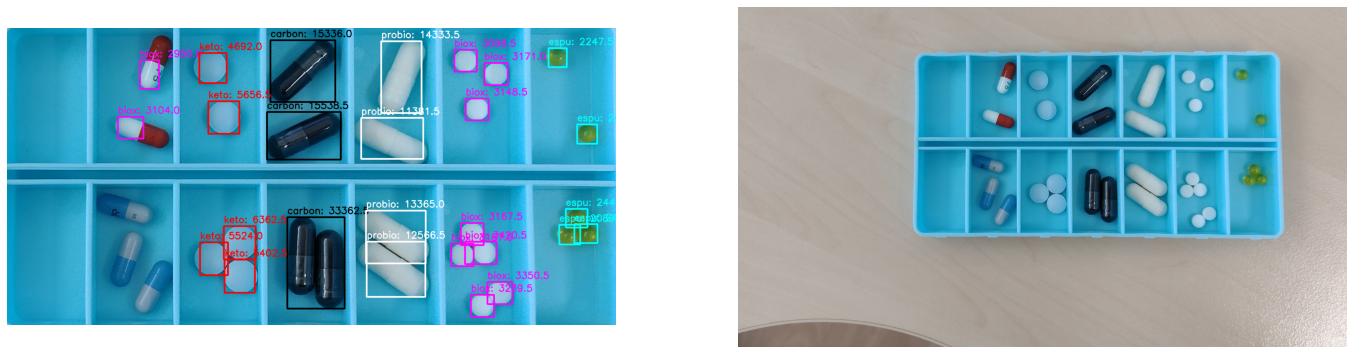

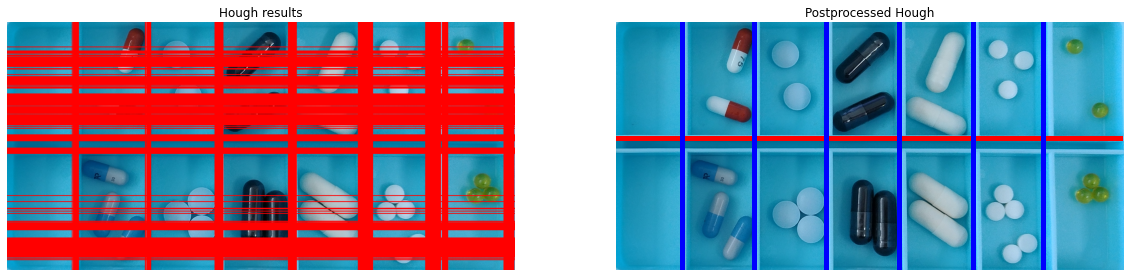

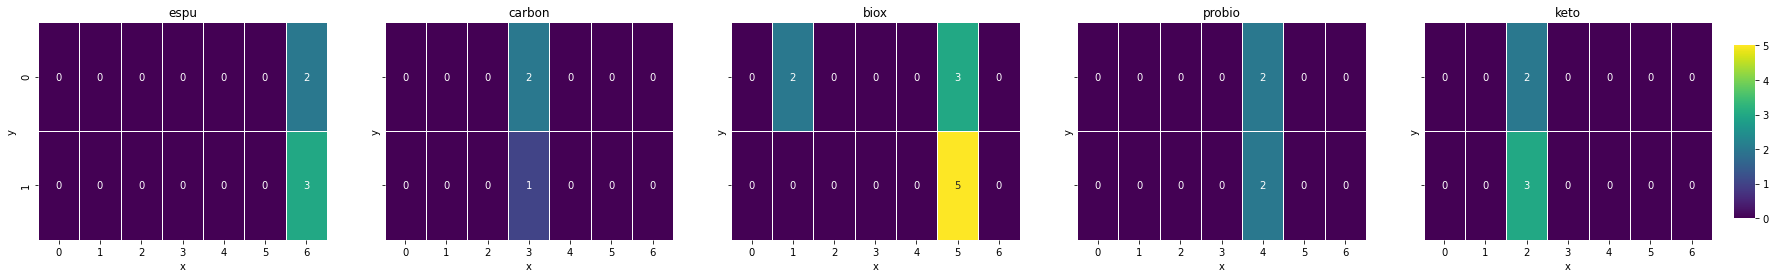

In [17]:
pcd = PillCellDetector()
objects, box, cells, lines, hough_lines = pcd.run(calib)

display_objects(calib, objects, box)
display_lines(lines, hough_lines, box)
display_cells_contents(cells)

#### TEST

Test 1

Calibrating canny:   0%|          | 0/10000 [00:00<?, ?it/s]


Calibrated configuration: (10, 10)


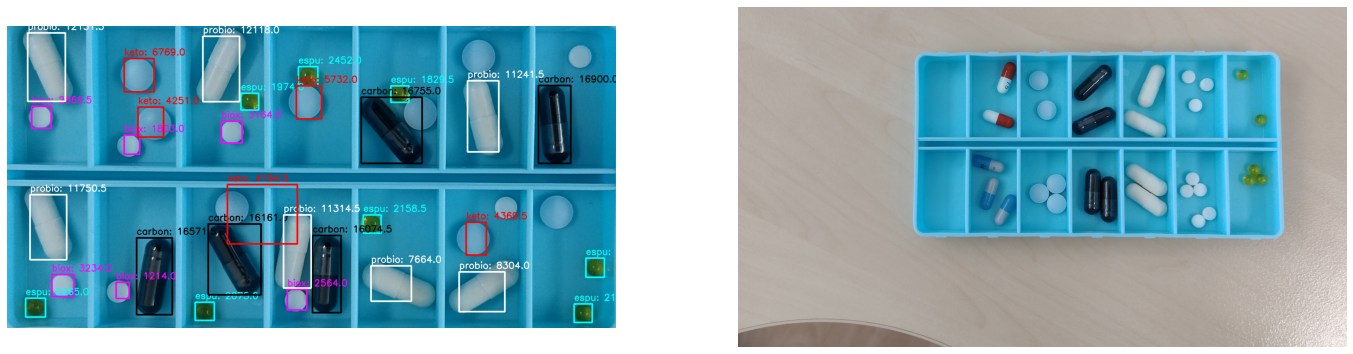

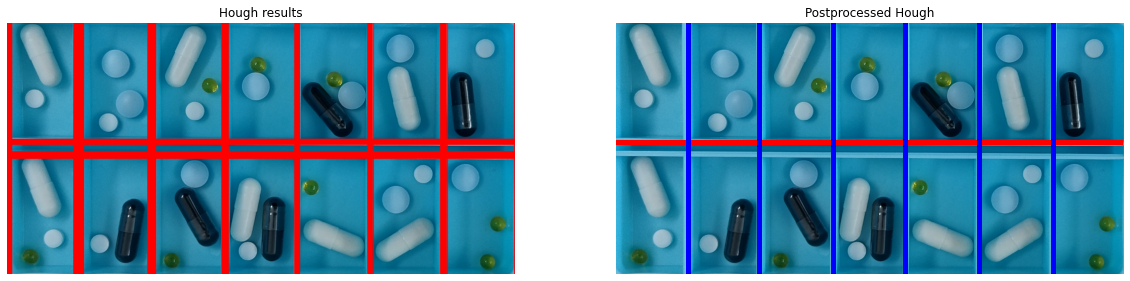

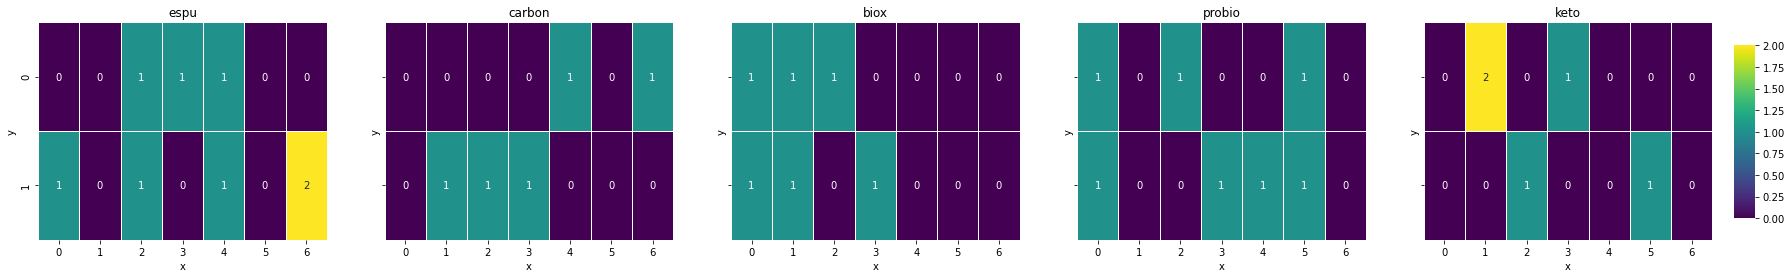

In [18]:
img = cv2.imread(f'Lab 5 - dane-20221024/test1.png')

pcd = PillCellDetector()
objects, box, cells, lines, hough_lines = pcd.run(img)

display_objects(calib, objects, box)
display_lines(lines, hough_lines, box)
display_cells_contents(cells)

Test 2

Calibrating canny:   0%|          | 0/10000 [00:00<?, ?it/s]


Calibrated configuration: (10, 10)


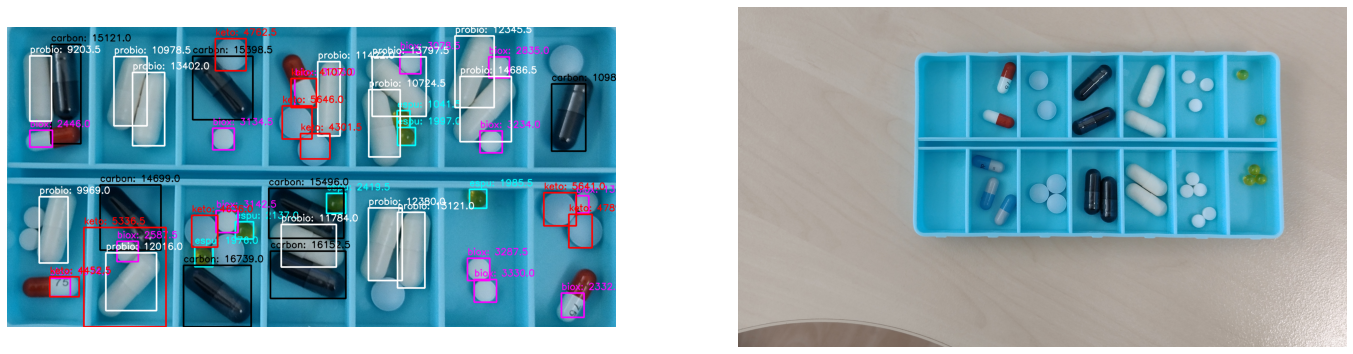

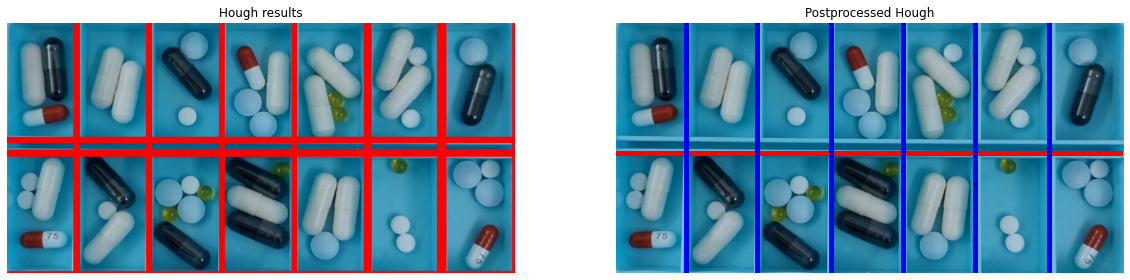

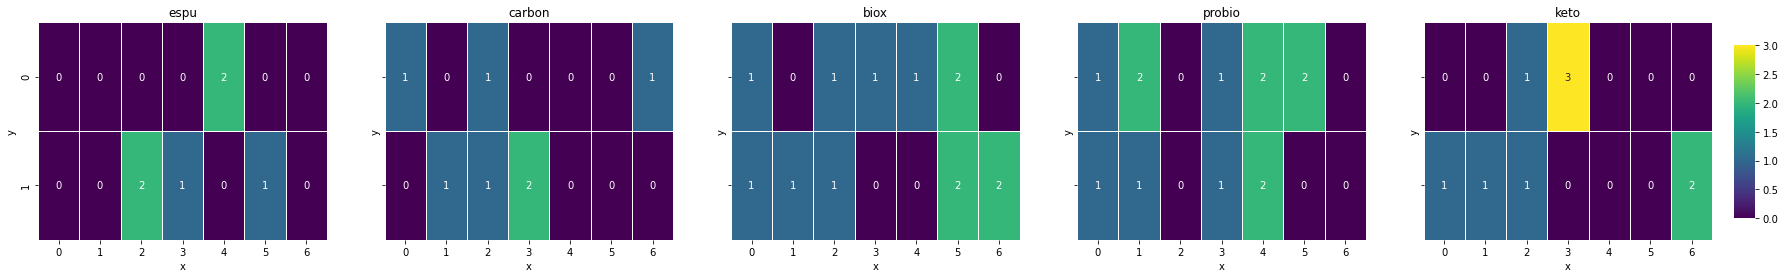

In [19]:
img = cv2.imread(f'Lab 5 - dane-20221024/test2.png')

pcd = PillCellDetector()
objects, box, cells, lines, hough_lines = pcd.run(img)

display_objects(calib, objects, box)
display_lines(lines, hough_lines, box)
display_cells_contents(cells)

Test 3 - nie udało się znaleźć odpowiedniej ilości linii

Calibrating canny:   0%|          | 0/10000 [00:00<?, ?it/s]


Calibrated configuration: (10, 10)


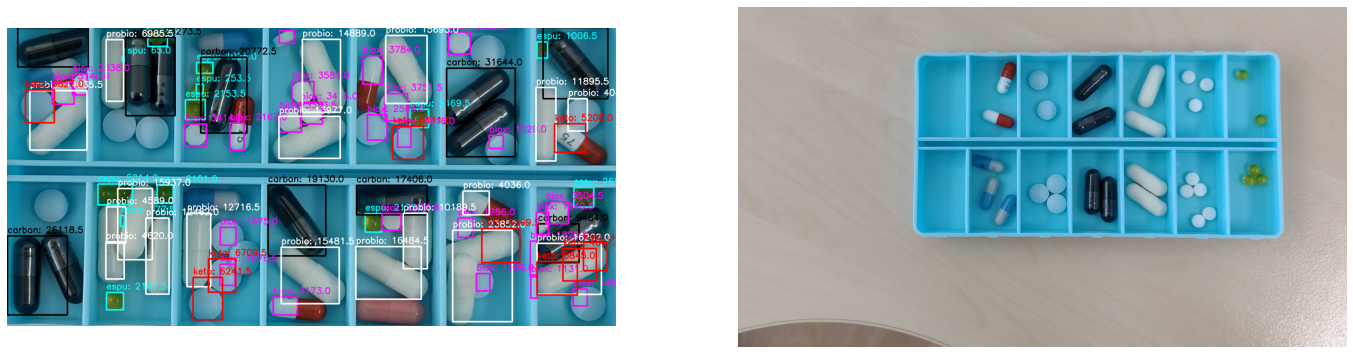

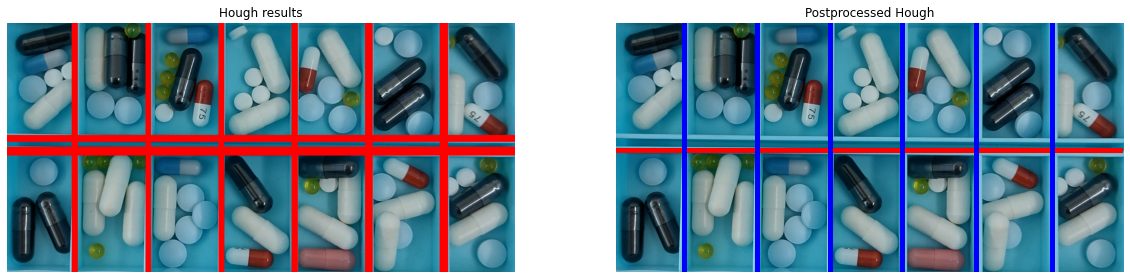

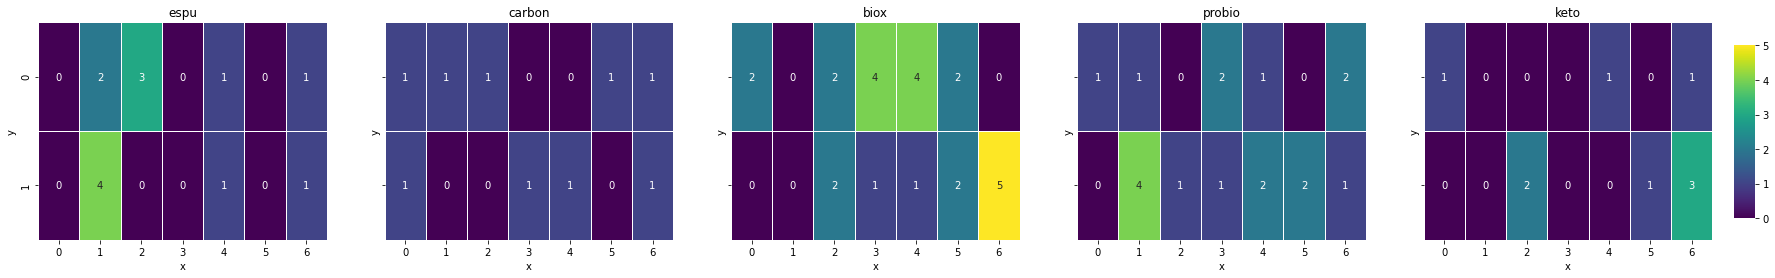

In [20]:
img = cv2.imread(f'Lab 5 - dane-20221024/test3.png')

pcd = PillCellDetector()
objects, box, cells, lines, hough_lines = pcd.run(img)

display_objects(calib, objects, box)
display_lines(lines, hough_lines, box)
display_cells_contents(cells)